## Навигация: <a class="anchor" id="contents"></a>

### 1. [Первичная оценка](#intro)
### 2. [Изучение признаков](#features)
### 3. [Графики](#plots)
### 4. [Предобработка признаков](#fe)
### 5. [Модели](#rnf)
#### 5.1. [RandomForestClassifier](#rnf)
#### 5.2. [LogisticRegression](#lr)
#### 5.3. [kNN (K-Nearest Neighbors)](#knn)

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [161]:
df = pd.read_csv('taxi.csv') 

### Небольшой датасет с 2-мя строковыми признаками:  <a class="anchor" id="intro"></a>

In [162]:
df.head(2)

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1


In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               100000 non-null float64
duration_min              100000 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dtypes: float64(6), int64(6), object(2)
memory usage: 10.7+ MB


In [164]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
offer_gk,100000,NaN,NaN,NaN,566219,325936,4,285555,565672,848720,1.13036e+06
weekday_key,100000,NaN,NaN,NaN,3.15986,2.05422,0,1,3,5,6
hour_key,100000,NaN,NaN,NaN,13.8278,7.3065,0,8,16,20,23
driver_gk,100000,NaN,NaN,NaN,3446.38,2038.74,14,1421,3506.5,5242,6806
order_gk,100000,NaN,NaN,NaN,460867,266065,18,229178,462420,690894,920344
driver_latitude,100000,NaN,NaN,NaN,55.7008,2.1359,-1,55.7087,55.7729,55.9607,56.1741
driver_longitude,100000,NaN,NaN,NaN,37.4923,1.45464,-1,37.4135,37.5337,37.6241,38.2805
origin_order_latitude,100000,NaN,NaN,NaN,55.7724,0.665985,-1,55.708,55.7726,55.962,56.3111
origin_order_longitude,100000,NaN,NaN,NaN,37.5416,0.467758,-1,37.4071,37.5325,37.6244,38.2436
distance_km,100000,NaN,NaN,NaN,18.3935,41.1293,-1,-1,10.4115,30.6653,5234.28


### Видим из `describe`:

1. Водитель берет заказ в 49% случаев.
2. `offer_class_group` имеет 9 уникальных значений, самый популярный `Economy` встречатеся в 48% случаев.
3. `ride_type_desc` имеет 4 уникальных значений, самый популярный `private` встречатеся в 91% случаев.
4. Отрицательные значения расстояния и времени нуждаются в доп. наблюдении.
5. Отмечаем наличие выбросов по признакам `distance_km` и `duration_min`.

[нашел подробное описание данных](https://www.crowdanalytix.com/contests/mckinsey-big-data-hackathon)

## Рассмотрю подробнее каждый признак в отдельности.<a class="anchor" id="features"></a> 
[к навигации](#contents)

In [165]:
cols = df.columns.to_list()

for f in cols[:-3]:
    print(f, 'have unique:', len(df[f].unique()),'\n')

offer_gk have unique: 100000 

weekday_key have unique: 7 

hour_key have unique: 24 

driver_gk have unique: 439 

order_gk have unique: 81435 

driver_latitude have unique: 57259 

driver_longitude have unique: 59906 

origin_order_latitude have unique: 32925 

origin_order_longitude have unique: 33646 

distance_km have unique: 31297 

duration_min have unique: 4728 



### Переназначу индексы, тк `offer_gk` соответствует количеству строк

In [166]:
df=df.set_index('offer_gk')

#### Изучаю строковые признаки

In [167]:
print('offer_class_group:', df.offer_class_group.unique(), '\n\n','ride_type_desc:', df.ride_type_desc.unique())

offer_class_group: ['Economy' 'Standard' 'XL' 'Kids' 'Delivery' 'Test' 'Premium' 'VIP' 'VIP+'] 

 ride_type_desc: ['private' 'business' 'affiliate' 'SMB']


In [168]:
df.groupby(by='offer_class_group').count().iloc[:,1]

offer_class_group
Delivery     1290
Economy     48335
Kids          588
Premium      1773
Standard    47288
Test            8
VIP           225
VIP+           29
XL            464
Name: hour_key, dtype: int64

#### Избавлюсь от `test` записей

In [169]:
df = df[df['offer_class_group'] != 'Test']

In [170]:
df.groupby(by='ride_type_desc').count().iloc[:,1]

ride_type_desc
SMB             28
affiliate      224
business      8533
private      91207
Name: hour_key, dtype: int64

#### Любопытно, что всего 16 из 28 заказов по `SMB`  были с уникальных адресов.

In [171]:
df[df['ride_type_desc'] == 'SMB']['origin_order_longitude'].unique().shape

(16,)

In [172]:
df[df['ride_type_desc'] == 'SMB'].sort_values(by='origin_order_latitude')

,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
offer_gk,,,,,,,,,,,,,
495538,3,22,2221,671093,55.544830,37.563338,55.548082,37.534335,23.995,36.467,Economy,SMB,1
601997,2,11,366,578212,55.611472,37.603327,55.600402,37.600737,-1.000,-1.000,Economy,SMB,1
319994,2,9,2381,611588,55.605225,37.286079,55.603777,37.290713,-1.000,-1.000,Economy,SMB,0
575946,6,1,2939,887084,55.666110,37.484688,55.661958,37.476465,15.449,21.600,Economy,SMB,1
102542,3,9,6450,532434,55.686647,37.572028,55.676650,37.559384,12.060,25.783,Economy,SMB,1
46063,5,13,5578,488670,55.678126,37.574338,55.681456,37.560491,5.267,16.983,Economy,SMB,1
336773,3,13,5420,649263,55.677257,37.549133,55.681456,37.560491,5.593,17.700,Economy,SMB,1
515011,4,14,1514,573660,55.679113,37.563873,55.681456,37.560491,5.593,17.517,Economy,SMB,1
1115050,5,13,4014,134774,55.678207,37.580621,55.681456,37.560491,5.300,17.033,Economy,SMB,1


#### Насколько понял это пол-грузовой автомобиль. Странного в данных мало, можно предположить что его заказывают для переездов или перевозки большого количества вещей.

#### Изучем влияние отрицательных значений на целевой признак:

In [14]:
selected_data = df[df['distance_km'] < 0]
print('водитель берет заказ в ',
      '{0:.0%}'.format(selected_data.driver_response.sum() / selected_data.shape[0]),     
      'случаев')
selected_data.describe(include='all').T

водитель берет заказ в  55% случаев


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
weekday_key,26199,NaN,NaN,NaN,3.18707,1.98494,0,1,3,5,6
hour_key,26199,NaN,NaN,NaN,13.9011,7.28034,0,9,16,20,23
driver_gk,26199,NaN,NaN,NaN,3403.57,2037.14,14,1421,3416,5222,6806
order_gk,26199,NaN,NaN,NaN,457941,265960,18,225610,460415,686572,920301
driver_latitude,26199,NaN,NaN,NaN,55.5167,3.86843,-1,55.7162,55.7676,55.9273,56.1741
driver_longitude,26199,NaN,NaN,NaN,37.3675,2.62848,-1,37.4135,37.5415,37.621,38.2805
origin_order_latitude,26199,NaN,NaN,NaN,55.7747,0.517457,-1,55.7166,55.767,55.9332,56.3111
origin_order_longitude,26199,NaN,NaN,NaN,37.5449,0.369381,-1,37.4089,37.5405,37.6219,38.2436
distance_km,26199,NaN,NaN,NaN,-1,0,-1,-1,-1,-1,-1
duration_min,26199,NaN,NaN,NaN,-1,0,-1,-1,-1,-1,-1


#### Ничего криминального, водители берут заказ с близкой к стандартной частотой. Что если неизвестна позиция водителя:

In [15]:
selected_data = df[df['driver_latitude'] < 0]
print('водитель берет заказ в ',
      '{0:.0%}'.format(selected_data.driver_response.sum() / selected_data.shape[0]),     
      'случаев')
selected_data.describe(include='all').T

водитель берет заказ в  100% случаев


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
weekday_key,140,NaN,NaN,NaN,3.01429,1.87749,0,1,3,5,6
hour_key,140,NaN,NaN,NaN,14.4429,6.035,0,11,14.5,19,23
driver_gk,140,NaN,NaN,NaN,4375.29,1943.23,14,3399,4567,6166,6792
order_gk,140,NaN,NaN,NaN,433850,279849,6975,202384,385691,676863,917874
driver_latitude,140,NaN,NaN,NaN,-1,0,-1,-1,-1,-1,-1
driver_longitude,140,NaN,NaN,NaN,-1,0,-1,-1,-1,-1,-1
origin_order_latitude,140,NaN,NaN,NaN,55.5164,0.175498,55.3362,55.4154,55.4154,55.6073,56.3111
origin_order_longitude,140,NaN,NaN,NaN,37.7847,0.200718,37.1689,37.6614,37.8989,37.8989,38.1326
distance_km,140,NaN,NaN,NaN,5.89409,20.3737,-1,-1,-1,-1,105.126
duration_min,140,NaN,NaN,NaN,6.19715,20.3018,-1,-1,-1,-1,92.55


#### Посмотрим на самые длительные поездки

In [16]:
long_trip = df.duration_min.mean()*2
very_long_trip = df.duration_min.mean()*5
longest_trip = df.duration_min.mean()*10

In [17]:
def long_trip_func(df, duration_min):

    print(f'всего заказов продолжительностию {duration_min} минут:', 
          df[df['duration_min'] > duration_min].count()[0],
         '\nиз них взял водитель:',
          df[((df['duration_min'] > duration_min) & (df['driver_response'] == 1))].shape[0],
         '\n============================')

In [18]:
long_trip_func(df, very_long_trip), long_trip_func(df, longest_trip), long_trip_func(df, 500), long_trip_func(df, 1000)

всего заказов продолжительностию 115.68386165893246 минут: 92 
из них взял водитель: 58 
всего заказов продолжительностию 231.36772331786491 минут: 61 
из них взял водитель: 42 
всего заказов продолжительностию 500 минут: 34 
из них взял водитель: 27 
всего заказов продолжительностию 1000 минут: 11 
из них взял водитель: 8 


(None, None, None, None)

In [19]:
df[df['duration_min'] > 1000]

,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
offer_gk,,,,,,,,,,,,,
198416,4,17,2333,914494,55.733757,37.405701,55.734689,37.402236,1479.538,1014.283,Standard,private,0
873470,1,16,6580,660752,55.831685,37.453510,55.827200,37.444590,1475.580,1149.667,Standard,private,0
174541,1,20,5714,706021,55.808453,37.527302,55.809480,37.529113,1725.533,1254.050,Economy,private,1
391059,6,15,2410,633727,55.602245,37.589453,55.592491,37.609445,1474.938,1159.000,XL,private,1
552747,1,18,6666,219128,55.746030,37.537630,55.757527,37.549621,5215.793,3947.383,VIP,private,1
538141,6,18,994,463224,55.767603,37.600957,55.769065,37.604302,4177.900,3112.217,Standard,private,1
106985,2,12,1420,225632,55.713349,37.610444,55.712851,37.615602,1808.875,1389.567,Economy,private,1
168924,6,21,989,452759,55.729859,37.654583,55.736360,37.655954,1512.828,1019.000,Economy,private,1
158777,2,20,3309,636962,55.719059,37.628675,55.728879,37.623929,3563.968,2721.000,Standard,private,1


#### Сложно назвать данные по длительным поездкам выбросами, оставим все как есть.

## Изучим корреляцию и распределение:<a class="anchor" id="plots"></a>
[к навигации](#contents)

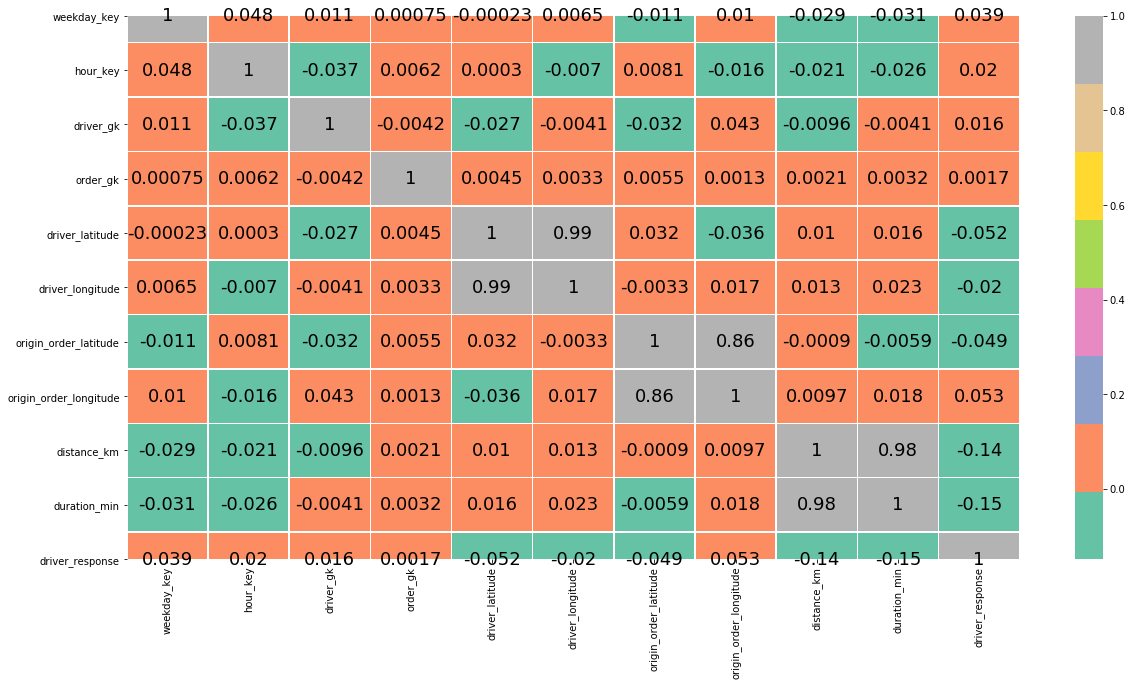

In [20]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.heatmap(df.corr(), cmap='Set2', annot=True, linewidths=0.4, annot_kws={"size": 18, 'color':'black'})

#### Очивидные зависимости. Распределение по дням и часам:

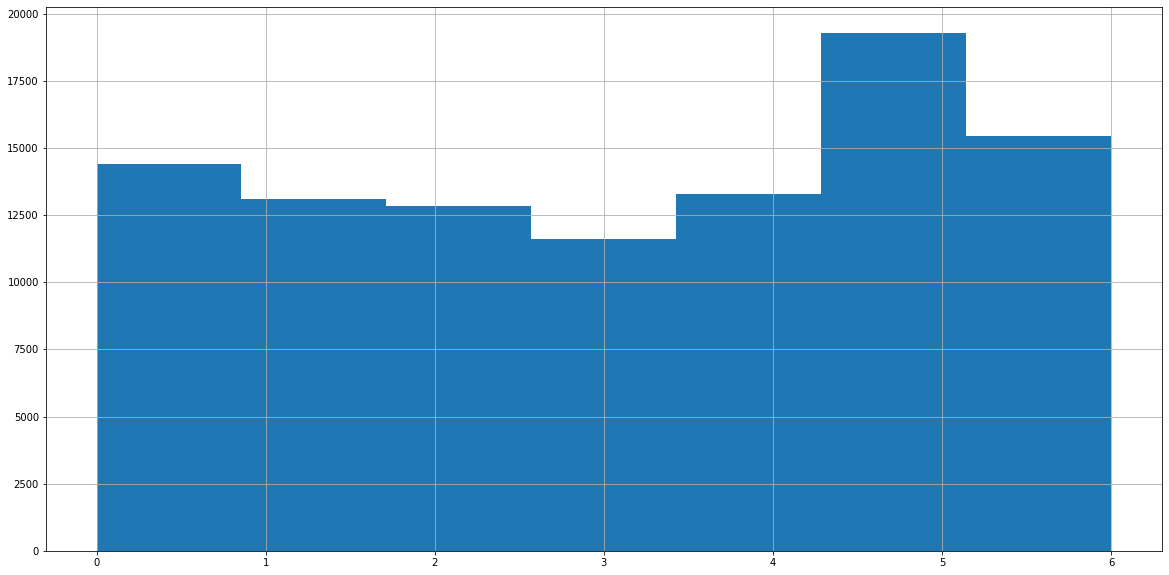

In [21]:
df.weekday_key.hist(bins=7)

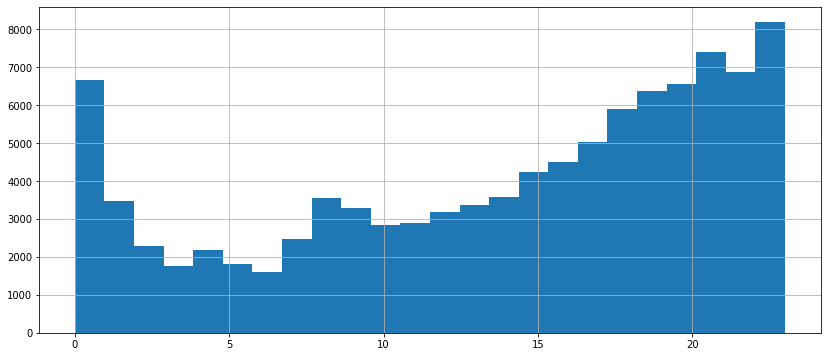

In [22]:
plt.rcParams['figure.figsize'] = (14.0, 6.0)
df.hour_key.hist(bins=24)

### Предобработаем строковые данные для моделей<a class="anchor" id="fe"></a>
[к навигации](#contents)

In [255]:
X = df.iloc[:,:-1]

In [256]:
X.offer_class_group.unique()

array(['Economy', 'Standard', 'XL', 'Kids', 'Delivery', 'Premium', 'VIP',
       'VIP+'], dtype=object)

#### Думаю что 'XL', 'Kids', 'Delivery' больше похоже на доп. опцию — вынисем их как отдельные фичи. Остальные классы распределим по возрастанию премиальности авто.

In [257]:
X['Delivery'] = X['offer_class_group'] == 'Delivery'
X['Kids'] = X['offer_class_group'] == 'Kids'
X['XL'] = X['offer_class_group'] == 'XL'

In [258]:
class_group = {"offer_class_group":     {'Delivery': 0,
                                         'Kids': 0,
                                         'XL': 0,
                                        "Economy": 1,
                                          "Standard": 2,
                                         'Premium': 3,
                                         'VIP': 4,
                                         'VIP+': 5}}

X.replace(class_group, inplace=True)

In [259]:
X['ride_type_desc'] = X['ride_type_desc'].astype('category')
X['ride_type_desc'] = X['ride_type_desc'].cat.codes

In [260]:
X = X.replace([True,False],[1,0])

In [261]:
X.head(2)

,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,Delivery,Kids,XL
offer_gk,,,,,,,,,,,,,,,
1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,1,3,0,0,0
759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,2,3,0,0,0


In [207]:
feature_list = list(X.columns)
len(feature_list)

15

In [208]:
y = df.driver_response

In [209]:
y.head()

offer_gk
1105373    0
759733     1
416977     0
889660     1
1120055    1
Name: driver_response, dtype: int64

#### Собрал данные для моделей, начинаю предсказывать.

### Импортируем библиотеки и делим данные (25/75).

In [262]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Импользуем RandomForestClassifier как модель прогнозирования таргета и оценки важности признаков<a class="anchor" id="rnf"></a>
[к навигации](#contents)

In [212]:
from sklearn.ensemble import RandomForestClassifier

#### Возму функцию для определения важности признаков отсюда: [build a forest and compute the feature importances](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

Feature ranking:
1. driver_latitude (0.155849)
2. origin_order_latitude (0.154046)
3. driver_longitude (0.130788)
4. origin_order_longitude (0.116430)
5. driver_gk (0.099679)
6. order_gk (0.076490)
7. distance_km (0.074221)
8. duration_min (0.069944)
9. hour_key (0.059580)
10. weekday_key (0.033048)
11. offer_class_group (0.021835)
12. ride_type_desc (0.004689)
13. Delivery (0.001232)
14. XL (0.001150)
15. Kids (0.001021)


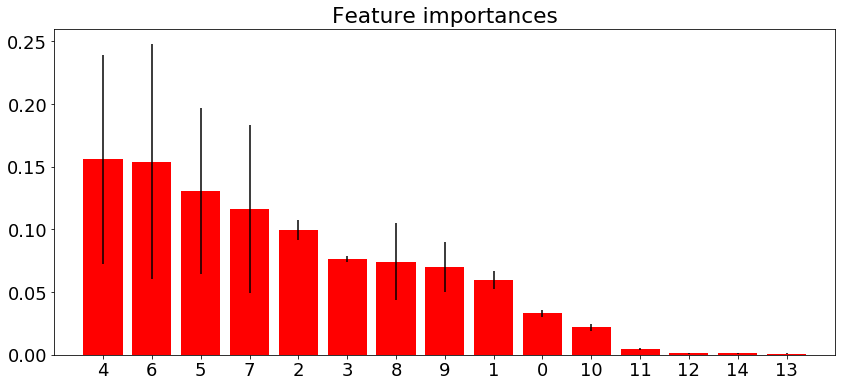

In [342]:
clf_RF = RandomForestClassifier(n_estimators=250,
                              random_state=10,
                              n_jobs=-1)

clf_RF.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_RF.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_list[indices[f]], importances[indices[f]]))
    

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

#### Видим, что RF наиболее значимыми прзнаками определил координаты водителя и места откуда предполагается начало поездки. Логично. К самым незначительным отнесены временные показатели, опции класса машин и тип поездки.

#### Оценим качество модели с помощью ROC-кривой и матрицы ошибок.

In [343]:
def show_auc(y, y_pred, plot_label='', prin=True):    
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.plot([0, 1], [0, 1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.xlabel
        plt.title('ROC curve')
        plt.savefig("ROC.png")
    return auc_val

Train:
ROC AUC: 0.9900
Test:
ROC AUC: 0.9902


0.9902231281360201

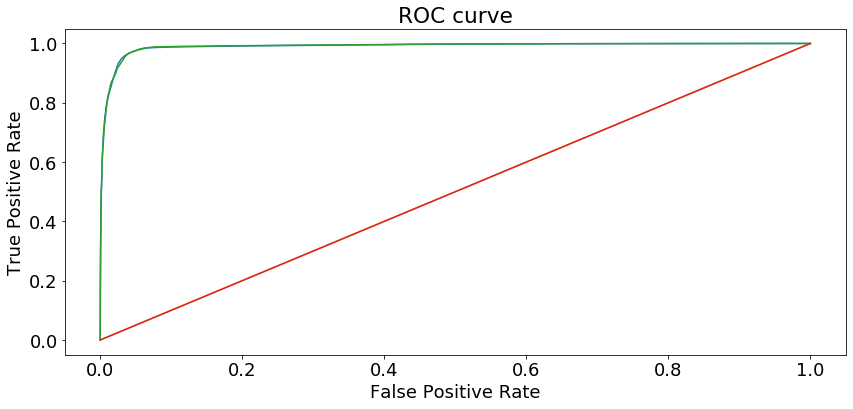

In [344]:
y_RF_pred_train = forest.predict_proba(X_train)[:,1]
y_RF_pred_test = forest.predict_proba(X_test)[:,1]

print('Train:')
show_auc(y_train, y_RF_pred_train, 'train')
         
print('Test:')
show_auc(y_test, y_RF_pred_test, 'test')

In [345]:
# округлим ответы модели, чтобы вывести отчет по классификации
y_RF_pred_test_round = np.around(y_RF_pred_test)

In [346]:
target_names = ['такси не работает', 'поехали!']
print(classification_report(y_test, y_RF_pred_test_round, target_names=target_names))

                   precision    recall  f1-score   support

такси не работает       0.98      0.95      0.96     12747
         поехали!       0.95      0.98      0.96     12251

        micro avg       0.96      0.96      0.96     24998
        macro avg       0.96      0.96      0.96     24998
     weighted avg       0.96      0.96      0.96     24998



Normalized confusion matrix
[[0.94932141 0.05067859]
 [0.02399804 0.97600196]]


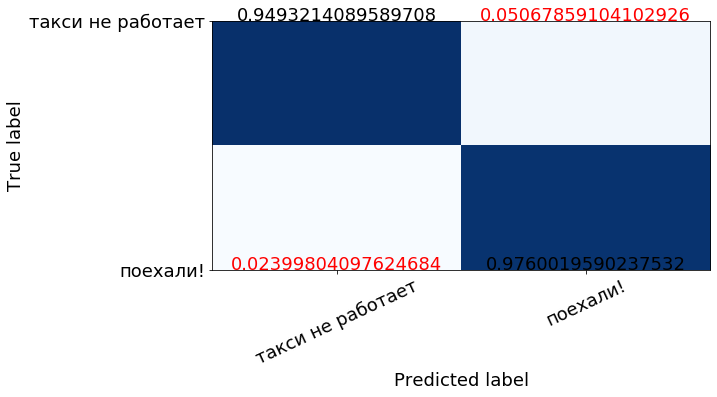

In [347]:
from itertools import product

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title, {'verticalalignment': 'top'})

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=25)
    plt.yticks(tick_marks, classes, )

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     verticalalignment = 'baseline',
                     color="black" if cm[i, j] > thresh else "red")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 18}

plt.rc('font', **font)



cnf_matrix = confusion_matrix(y_test, y_RF_pred_test_round)

plt.figure(figsize=(10,19))


plot_confusion_matrix(cnf_matrix, classes=['такси не работает', 'поехали!'],
                      title='Confusion matrix')

plt.show()

In [348]:
accuracy_score(y_test, y_RF_pred_test_round)

0.9623969917593408

#### Случайный лес показал отличные результаты со всех ракурсов.

## Посмотрим как с той же задачей справится LogisticRegression<a class="anchor" id="lr"></a>
[к навигации](#contents)

In [349]:
from sklearn.linear_model import LogisticRegression

#### Стандартизирую признаки.

In [350]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train.values)

X_LR_train = scaler.transform(X_train)
X_LR_test = scaler.transform(X_test)

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [352]:
X_LR_train[:3]

array([[-0.07797691,  1.11571553,  0.22219277,  1.00797998,  0.02488356,
         0.08318136, -0.01741368,  0.17388792, -0.41451065, -0.52973112,
        -0.83763968,  0.30511741, -0.11254373, -0.07778303, -0.06668363],
       [ 0.89552068,  0.70491374, -1.40625359,  0.07896784,  0.01032224,
        -0.02895714, -0.07560979, -0.21053852, -0.14341266,  0.05121154,
         0.85725685,  0.30511741, -0.11254373, -0.07778303, -0.06668363],
       [-1.53822329,  0.29411196,  1.51387132,  0.73043709,  0.07249045,
        -0.01635902,  0.16790401, -0.20233069, -0.097224  , -0.11116772,
        -0.83763968,  0.30511741, -0.11254373, -0.07778303, -0.06668363]])

In [353]:
clf_LR = LogisticRegression(random_state=8)
clf_LR.fit(X_LR_train, y_train)

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=8, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [354]:
clf_LR.coef_[0]

array([ 0.01716242,  0.0367966 , -0.03848262,  0.01232173, -4.85420714,
        2.35650935,  0.20258629, -0.23170353, -2.64386806,  1.1610527 ,
        0.24649489,  0.01762366,  0.12016562,  0.17310562,  0.0959504 ])

In [355]:
d = dict(zip(feature_list, clf_LR.coef_[0]))
sorted(d.items(), key=lambda x: x[1], reverse=True)

[('driver_longitude', 2.356509349005559),
 ('duration_min', 1.1610526996084243),
 ('offer_class_group', 0.2464948890612462),
 ('origin_order_latitude', 0.20258628654190794),
 ('Kids', 0.17310562215543215),
 ('Delivery', 0.12016562191037954),
 ('XL', 0.09595040411464265),
 ('hour_key', 0.03679659505690758),
 ('ride_type_desc', 0.017623655097723862),
 ('weekday_key', 0.01716241989539708),
 ('order_gk', 0.012321729582977302),
 ('driver_gk', -0.038482622320442576),
 ('origin_order_longitude', -0.23170352774181754),
 ('distance_km', -2.6438680568561774),
 ('driver_latitude', -4.854207141186515)]

#### LR очень странным образом выделила значимые признаки, не наблюдаю логики.

Train:
ROC AUC: 0.7405
Test:
ROC AUC: 0.7424


0.7424197410230895

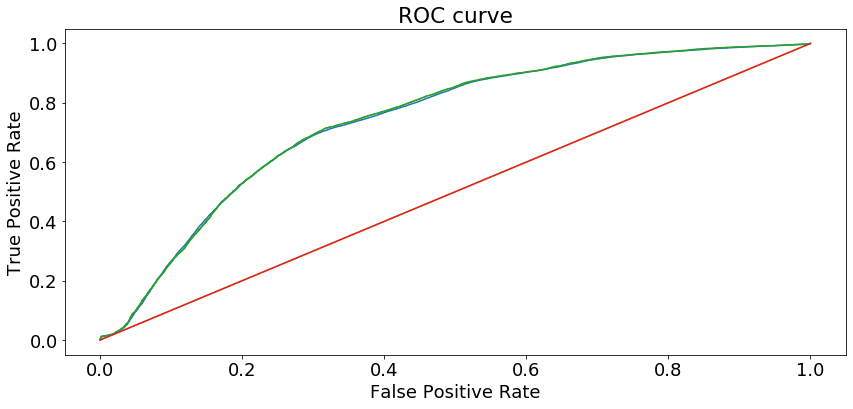

In [356]:
y_LR_pred_train = clf_LR.predict_proba(X_LR_train)[:,1]
y_LR_pred_test = clf_LR.predict_proba(X_LR_test)[:,1]

print('Train:')
show_auc(y_train, y_LR_pred_train, 'train')
         
print('Test:')
show_auc(y_test, y_LR_pred_test, 'test')

In [283]:
# округлим ответы модели, чтобы вывести отчет по классификации
y_LR_pred_test_round = np.around(y_LR_pred_test)

In [284]:
target_names = ['такси не работает', 'поехали']
print(classification_report(y_test, y_LR_pred_test_round, target_names=target_names))

                   precision    recall  f1-score   support

такси не работает       0.73      0.62      0.67     12747
          поехали       0.66      0.76      0.70     12251

        micro avg       0.69      0.69      0.69     24998
        macro avg       0.69      0.69      0.69     24998
     weighted avg       0.69      0.69      0.69     24998



Normalized confusion matrix
[[0.62147956 0.37852044]
 [0.24291895 0.75708105]]


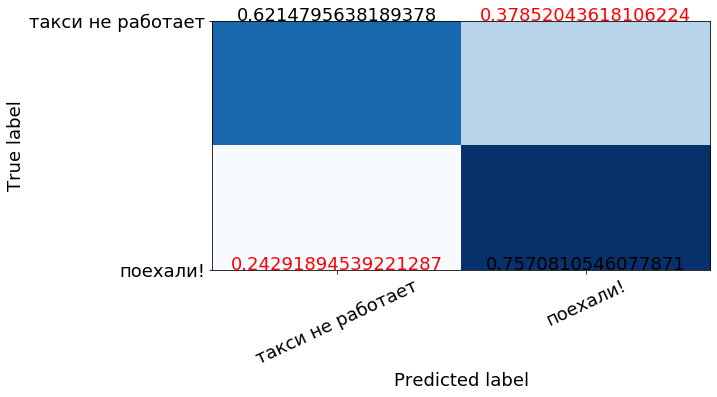

In [341]:
LR_cnf_matrix = confusion_matrix(y_test, y_LR_pred_test_round)
plt.figure(figsize=(10,12))
plot_confusion_matrix(LR_cnf_matrix, classes=['такси не работает', 'поехали!'],
                      title='Confusion matrix')

plt.show()

In [357]:
accuracy_score(y_test, y_LR_pred_test_round)

0.6879350348027842

In [358]:
def LR_coin(y_LR_pred_test, minimum=0.45, maximum=0.55):
    qty = 0
    for i in y_LR_pred_test:
        if minimum <= i <= maximum:
            qty += 1

    print(f'Всего наблюдений: {y_LR_pred_test.shape},\n',
    '{0:.0%}'.format(qty / y_LR_pred_test.shape[0]),
    f'({qty}) ответов регрессии в диапазоне от {minimum} до {maximum}')

In [359]:
LR_coin(y_LR_pred_test, minimum=0.45, maximum=0.55)

Всего наблюдений: (24998,),
 22% (5526) ответов регрессии в диапазоне от 0.45 до 0.55


#### Модель странно взвесила признаки и дала малую точность. Видим что в 22% случаев предсказание имеет почти случайный характер.

## Классифицируем на kNN<a class="anchor" id="knn"></a>
[к навигации](#contents)

In [360]:
from sklearn.neighbors import KNeighborsClassifier

In [361]:
clf_kNN = KNeighborsClassifier(n_neighbors=16, n_jobs=-1)
clf_kNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
           weights='uniform')

Train:
ROC AUC: 0.6904
Test:
ROC AUC: 0.5830


0.583040215857871

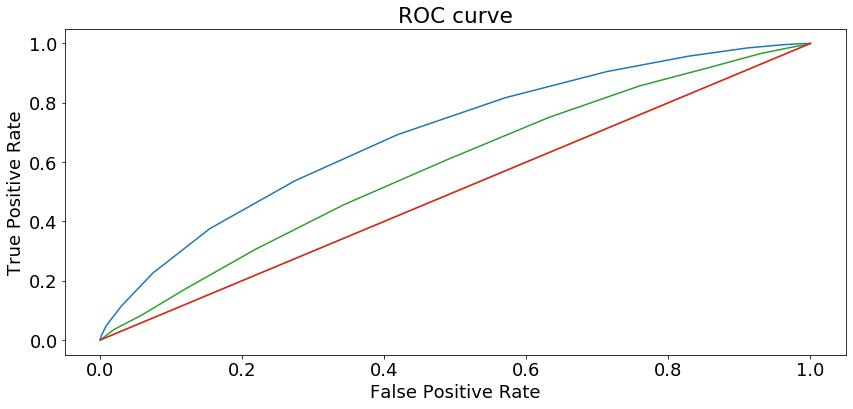

In [362]:
y_kNN_pred_train = clf_kNN.predict_proba(X_train)[:,1]
y_kNN_pred_test = clf_kNN.predict_proba(X_test)[:,1]

print('Train:')
show_auc(y_train, y_kNN_pred_train, 'train')
         
print('Test:')
show_auc(y_test, y_kNN_pred_test, 'test')

In [363]:
y_kNN_pred_test_round = np.around(y_kNN_pred_test)

In [364]:
print(classification_report(y_test, y_kNN_pred_test_round, target_names=target_names))

                   precision    recall  f1-score   support

такси не работает       0.56      0.66      0.60     12747
          поехали       0.56      0.46      0.50     12251

        micro avg       0.56      0.56      0.56     24998
        macro avg       0.56      0.56      0.55     24998
     weighted avg       0.56      0.56      0.55     24998



Normalized confusion matrix
[[0.65678199 0.34321801]
 [0.54362909 0.45637091]]


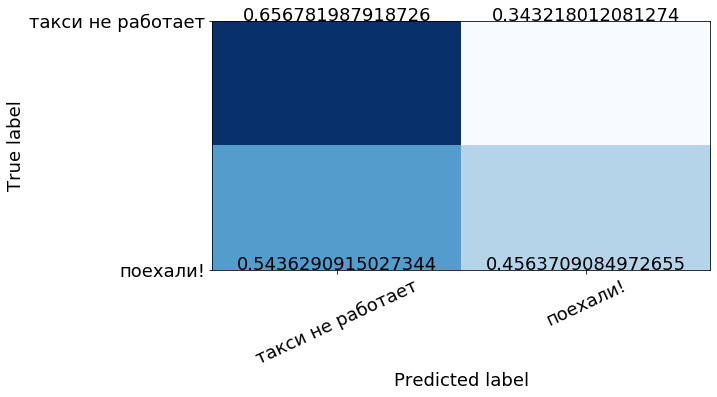

In [365]:
kNN_cnf_matrix = confusion_matrix(y_test, y_kNN_pred_test_round)

plt.figure(figsize=(10,12))


plot_confusion_matrix(kNN_cnf_matrix, classes=['такси не работает', 'поехали!'],
                      title='Confusion matrix')

plt.show()

In [366]:
accuracy_score(y_test, y_kNN_pred_test_round)

0.558564685174814

#### [Наихудшее качество среди всех моделей, узнаем можно ли оптимизировать меняя количество соседей.](https://datascienceplus.com/k-nearest-neighbors-knn-with-python/)

In [367]:
error_rate = []
# Might take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

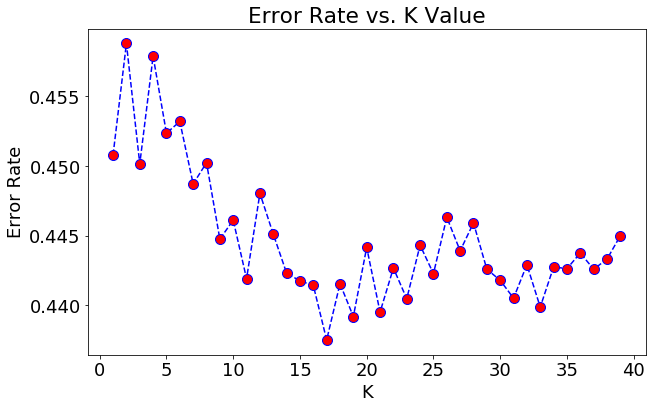

In [368]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [369]:
error_rate[15:20]

[0.441435314825186,
 0.437515001200096,
 0.4415553244259541,
 0.4391951356108489,
 0.4441555324425954]

#### Видим, что оптимальное количество соседей = 16, но качество предсказаний низкое все равно. Попробуем прогнать kNN на стандартизированных данных.

Train:
ROC AUC: 0.8547
Test:
ROC AUC: 0.8104


0.8104370703225223

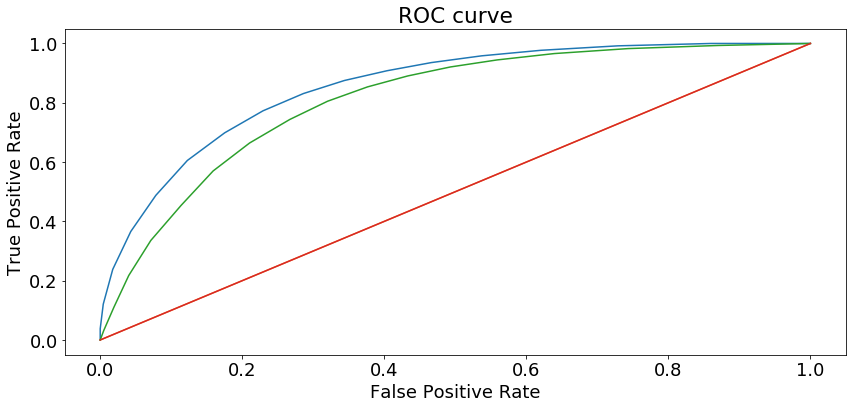

In [370]:
clf_kNN_opt = KNeighborsClassifier(n_neighbors=16, n_jobs=-1)
clf_kNN_opt.fit(X_LR_train, y_train)

y_kNN_pred_train_2 = clf_kNN_opt.predict_proba(X_LR_train)[:,1]
y_kNN_pred_test_2 = clf_kNN_opt.predict_proba(X_LR_test)[:,1]

print('Train:')
show_auc(y_train, y_kNN_pred_train_2, 'train')
         
print('Test:')
show_auc(y_test, y_kNN_pred_test_2, 'test')

In [372]:
y_kNN_pred_test_2_round = np.around(y_kNN_pred_test_2)

print(classification_report(y_test, y_kNN_pred_test_2_round, target_names=target_names))

                   precision    recall  f1-score   support

такси не работает       0.75      0.73      0.74     12747
          поехали       0.73      0.74      0.74     12251

        micro avg       0.74      0.74      0.74     24998
        macro avg       0.74      0.74      0.74     24998
     weighted avg       0.74      0.74      0.74     24998



In [373]:
accuracy_score(y_test, y_kNN_pred_test_2_round)

0.738259060724858

#### Выполнив ряд преобразований, удалось поднять качество классификации kNN до 73% и обогнать логистическую регрессию по качеству.

## Вернуться к разделам:

### 1. [Первичная оценка](#intro)
### 2. [Изучение признаков](#features)
### 3. [Графики](#plots)
### 4. [Предобработка признаков](#fe)
### 5. [Модели](#rnf)
#### 5.1. [RandomForestClassifier](#rnf)
#### 5.2. [LogisticRegression](#lr)
#### 5.3. [kNN (K-Nearest Neighbors)](#knn)